In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv
/kaggle/input/predicting-depression-machine-learning-challenge/train.csv
/kaggle/input/predicting-depression-machine-learning-challenge/test.csv


=== Starting Depression Prediction Pipeline ===

Loading data...

=== Starting Data Preprocessing ===
Numerical columns: 9
Categorical columns: 10

Handling missing values...

Encoding categorical variables...

Applying SMOTE to handle class imbalance...

Scaling numerical features...

=== Selecting Most Significant Features ===
Selected Features: ['Name', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress']

=== Comparing Base Models ===

Training Logistic Regression...
Logistic Regression Accuracy: 0.9333

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     23027
           1       0.93      0.94      0.93     23027

    accuracy                           0.93     46054
   macro avg       

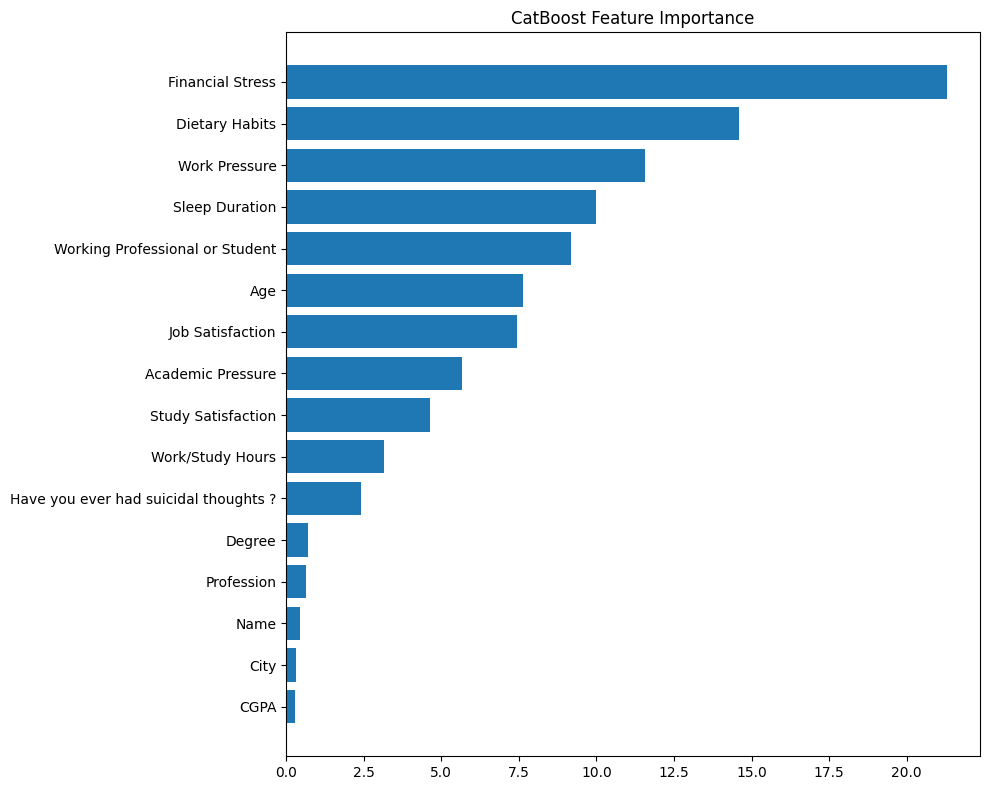


Making predictions on test set...

Submission file created successfully!


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

def analyze_data(df):
    """Initial data analysis and visualization"""
    print("\n=== Dataset Overview ===")
    print(f"Dataset shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())
    
    print("\nTarget distribution:")
    target_dist = df['Depression'].value_counts(normalize=True)
    print(target_dist)
    
    # Visualize target distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Depression')
    plt.title('Distribution of Depression Cases')
    plt.show()

def enhanced_preprocessing(train, test):
    print("\n=== Starting Data Preprocessing ===")
    
    # Separate numeric and categorical columns
    target_col = 'Depression'
    numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns.drop(target_col, errors='ignore')
    categorical_cols = train.select_dtypes(include=['object']).columns
    
    print(f"Numerical columns: {len(numeric_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")
    
    # Handle missing values more efficiently
    print("\nHandling missing values...")
    
    # For numerical columns: Use median imputation
    numeric_imputer = SimpleImputer(strategy='median')
    train[numeric_cols] = numeric_imputer.fit_transform(train[numeric_cols])
    test[numeric_cols] = numeric_imputer.transform(test[numeric_cols])
    
    # For categorical columns: Use most frequent imputation
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    train[categorical_cols] = categorical_imputer.fit_transform(train[categorical_cols])
    test[categorical_cols] = categorical_imputer.transform(test[categorical_cols])
    
    # Encode categorical variables
    print("\nEncoding categorical variables...")
    label_encoders = {}
    for col in categorical_cols:
        unique_vals = pd.concat([train[col], test[col]]).unique()
        le = LabelEncoder()
        le.fit(unique_vals)
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        label_encoders[col] = le
    
    # Apply SMOTE to balance classes
    print("\nApplying SMOTE to handle class imbalance...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(train.drop(columns=[target_col]), train[target_col])
    train = pd.concat([pd.DataFrame(X_resampled, columns=train.drop(columns=[target_col]).columns), pd.DataFrame(y_resampled, columns=[target_col])], axis=1)
    
    # Scale numerical features
    print("\nScaling numerical features...")
    scaler = RobustScaler()
    train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
    test[numeric_cols] = scaler.transform(test[numeric_cols])
    
    return train, test, label_encoders

def feature_selection(X, y):
    print("\n=== Selecting Most Significant Features ===")
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    selected_features = feature_importances[feature_importances > 0.01].index.tolist()
    print("Selected Features:", selected_features)
    return X[selected_features], selected_features

def compare_base_models(X_train, X_test, y_train, y_test):
    print("\n=== Comparing Base Models ===")
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=10000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    # Select best model
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    print(f"\nBest Model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")
    
    return best_model, best_model_name

def tune_catboost(X_train, y_train, X_val, y_val):
    print("\n=== Tuning CatBoost Hyperparameters ===")
    
    # Define a compact parameter grid to avoid excessive tuning time
    param_grid = {
        'iterations': [500, 1000],
        'learning_rate': [0.05, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [3, 7]
    }
    
    # Initialize CatBoost classifier with early stopping
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        verbose=False,
        random_seed=42,
        early_stopping_rounds=50
    )
    
    # Use 3-fold cross-validation to speed up the process
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Print best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate on validation set
    best_model = grid_search.best_estimator_
    val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    print(f"Validation accuracy with tuned model: {val_accuracy:.4f}")
    
    return best_model

def main():
    print("=== Starting Depression Prediction Pipeline ===")
    
    # Load data
    print("\nLoading data...")
    train = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/train.csv')
    test = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/test.csv')
    
    test_ids = test['id'].copy()
    
    # Preprocessing
    train, test, label_encoders = enhanced_preprocessing(train, test)
    
    # Prepare features and target
    X = train.drop(['Depression', 'id'], axis=1)
    y = train['Depression']
    test_features = test.drop(['id'], axis=1)
    
    # Feature selection
    X, selected_features = feature_selection(X, y)
    test_features = test_features[selected_features]
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Compare base models
    best_model, best_model_name = compare_base_models(X_train, X_val, y_train, y_val)
    
    # If CatBoost is the best model, tune it
    if best_model_name == 'CatBoost':
        print("\n=== CatBoost was the best model, proceeding with hyperparameter tuning ===")
        tuned_model = tune_catboost(X_train, y_train, X_val, y_val)
        
        # Compare tuned model with base model
        base_pred = best_model.predict(X_val)
        base_accuracy = accuracy_score(y_val, base_pred)
        
        tuned_pred = tuned_model.predict(X_val)
        tuned_accuracy = accuracy_score(y_val, tuned_pred)
        
        print(f"\nBase CatBoost accuracy: {base_accuracy:.4f}")
        print(f"Tuned CatBoost accuracy: {tuned_accuracy:.4f}")
        
        # Use the tuned model if it's better
        if tuned_accuracy > base_accuracy:
            best_model = tuned_model
            print("Using tuned CatBoost model for final predictions.")
        else:
            print("Base CatBoost model performed better, using it for final predictions.")
    
    # Train final model on full dataset
    print(f"\n=== Training Final {best_model.__class__.__name__} Model ===")
    best_model.fit(X, y)
    
    # Feature importance visualization for CatBoost
    if isinstance(best_model, CatBoostClassifier):
        feature_importance = best_model.get_feature_importance()
        sorted_idx = np.argsort(feature_importance)
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
        plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
        plt.title('CatBoost Feature Importance')
        plt.tight_layout()
        plt.show()
    
    # Make predictions on test set
    print("\nMaking predictions on test set...")
    final_predictions = best_model.predict(test_features)
    
    # Create submission file
    submission = pd.DataFrame({
        'id': test_ids,
        'Depression': final_predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("\nSubmission file created successfully!")
    
    return submission, best_model

if __name__ == "__main__":
    submission, model = main()